# Permutation Feature Importance vs Impurity-based Feature Importance 

## Estudio Previo

En este ejemplo, voy a comparar Impurity-based Feature Importance de un Random Forest con Permutation Feature Importance en el conjunto de datos de GermanRisk (al final del todo hay un anexo donde cuento mi interpretación Naive antes de modelar). Quiero mostrar que la importancia de características basada en la impureza puede inflar la importancia de características numéricas y que sufre especialmente con el overfitting (las importancias pueden ser altas incluso para características que no son predictivas de la variable objetivo, siempre y cuando el modelo tenga la capacidad de usarlas para sobreajustar).

Pretendo ejemplificar cómo utilizar PFI como alternativa que puede mitigar esas limitaciones.

## Ejemplos específicos

Vamos a usar la base de datos de germanRisk y random forest para este experimento.

He preparado cinco opciones, las cuatro últimas funcionan peor por mi preprocesamiento previo, la base de datos estaba ya pensada para modelar directamente y hay mucho one-hot encoding por no tener claro si las categorías estaban relacionadas o no:

0. Esta opción es con la base de datos original y es la que mejores resultados da.
1. Como he visto que hacen en la referencia de donde he sacado la idea: random forest overfitting con dos varibles aleatorias inventadas.
2. Random forest overfitting sin variables extras.
3. Random forest sin overfitting de mi entrenamiento y con dos variables extras.
4. Random forest sin overfitting sin las dos variables extras.

# 0. Opción sin mi pre-modelización

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder

# Leer la base de datos
url = "data/german_credit_data.csv" 
datos = pd.read_csv(url)
# Quito la primera columna que es un id
datos.drop(datos.columns[0], axis=1, inplace=True)

# Generamos dos variables aleatorias que no aportan nada al modelo
rng = np.random.RandomState(seed=0)
datos["random_cat"] = rng.randint(3, size=datos.shape[0])
datos["random_num"] = rng.randn(datos.shape[0])

# Dividir los datos en características (X) y etiquetas (y)
X = datos.drop('Risk', axis=1)
y = datos['Risk']

# Dividir los datos en conjunto de entrenamiento y conjunto de prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Definir las columnas categóricas y numéricas
categorical_columns = ["Sex", "Housing", "Saving accounts", "Checking account", "random_cat"]
numerical_columns = ["Age", "Job", "Credit amount", "Duration", "random_num"]

# Crear el codificador ordinal y el imputador simple
categorical_encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1, encoded_missing_value=-1)
numerical_pipe = SimpleImputer(strategy="mean")

# Definir el preprocesamiento de datos
preprocessing = ColumnTransformer(
    [
        ("cat", categorical_encoder, categorical_columns),
        ("num", numerical_pipe, numerical_columns),
    ],
    verbose_feature_names_out=False,
)

# Crear el modelo de RandomForest
rf = Pipeline(
    [
        ("preprocess", preprocessing),
        ("classifier", RandomForestClassifier(random_state=42)),
    ]
)

# Entrenar el modelo
rf.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OrdinalEncoder(encoded_missing_value=-1,
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['Sex', 'Housing',
                                                   'Saving accounts',
                                                   'Checking account',
                                                   'random_cat']),
                                                 ('num', SimpleImputer(),
                                                  ['Age', 'Job',
                                                   'Credit amount', 'Duration',
                                                   'random_num'])],
                                   verbose_feature_names_out=False)),
                ('classifier', RandomForestClassifier(random_state=42))])

In [2]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Predecir las etiquetas del conjunto de entrenamiento y prueba
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

# Calcular las métricas de precisión
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

precision = precision_score(y_test, y_test_pred, pos_label='good')
recall = recall_score(y_test, y_test_pred, pos_label='good')
f1 = f1_score(y_test, y_test_pred, pos_label='good')

print(f"RF train accuracy: {train_accuracy:.3f}")
print(f"RF test accuracy: {test_accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 Score: {f1:.3f}")

RF train accuracy: 1.000
RF test accuracy: 0.760
Precision: 0.809
Recall: 0.866
F1 Score: 0.837


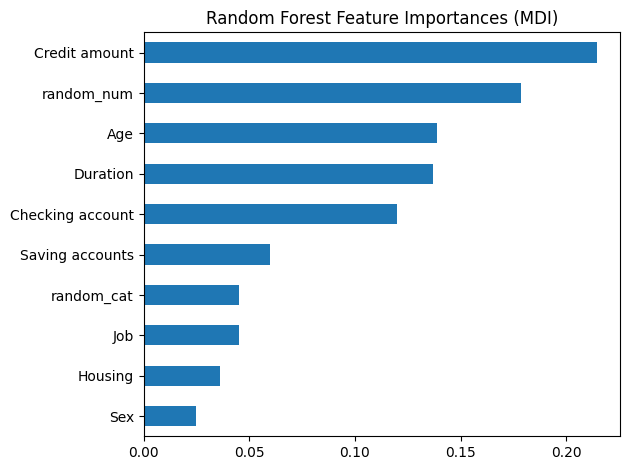

In [131]:
import pandas as pd

feature_names = rf[:-1].get_feature_names_out()

mdi_importances = pd.Series(
    rf[-1].feature_importances_, index=feature_names
).sort_values(ascending=True)

ax = mdi_importances.plot.barh()
ax.set_title("Random Forest Feature Importances (MDI)")
ax.figure.tight_layout()


Vemos que la importancia de características basada en la disminución media de la impureza (MDI) clasifica las características numéricas como las más importantes. Como resultado, la variable random_num no predictiva se clasifica como una de las características más importantes.

Este problema surge de dos limitaciones de las importancias de características basadas en la impureza:
- Las importancias basadas en la impureza están sesgadas hacia características de alta cardinalidad.
- Las importancias basadas en la impureza se calculan en estadísticas del conjunto de entrenamiento y, por lo tanto, no reflejan la capacidad de las características para ser útiles para hacer predicciones que se generalicen al conjunto de prueba (cuando el modelo tiene suficiente capacidad).

El sesgo hacia características de alta cardinalidad explica por qué random_num tiene una importancia muy alta en comparación con random_cat, mientras que esperaríamos que ambas características aleatorias tuvieran una importancia nula.

El hecho de que usemos estadísticas del conjunto de entrenamiento explica por qué tanto random_num como random_cat tienen una importancia no nula.

Sin embargo si usamos PFI:

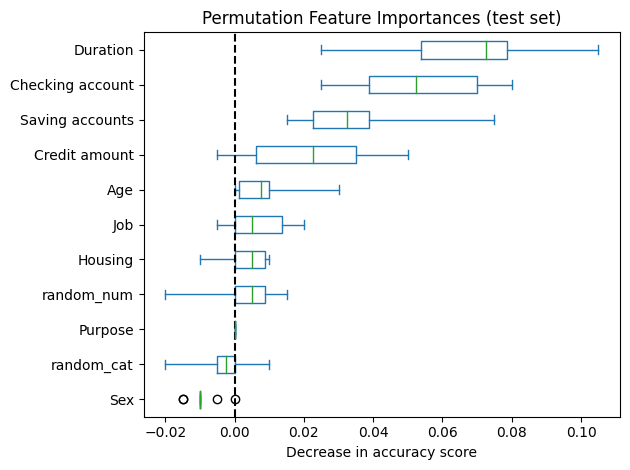

In [134]:
from sklearn.inspection import permutation_importance

result = permutation_importance(
    rf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)

sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=X.columns[sorted_importances_idx],
)
ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Feature Importances (test set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()

Como alternativa, las importancias por permutación de rf se calculan en un conjunto de prueba retenido. Esto muestra que las características categóricas de baja cardinalidad, sex y pclass, son las más importantes. De hecho, permutar los valores de estas características conducirá a la mayor disminución en la puntuación de precisión del modelo en el conjunto de prueba.

También se nota que ambas características aleatorias tienen importancias muy bajas (cerca de 0), como se esperaba.

### Extra Overfitting: PFI en train

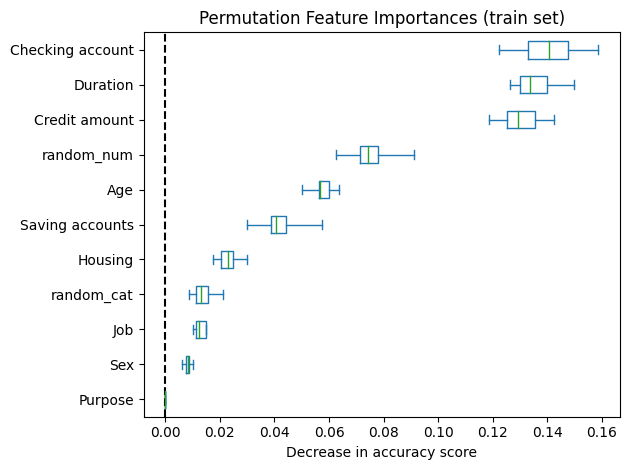

In [135]:
from sklearn.inspection import permutation_importance

result = permutation_importance(
    rf, X_train, y_train, n_repeats=10, random_state=42, n_jobs=2
)

sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=X.columns[sorted_importances_idx],
)
ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Feature Importances (train set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()

Esto revela que random_num y random_cat obtienen un ranking de importancia significativamente más alto que cuando se calcula en el conjunto de prueba. La diferencia entre estos dos gráficos confirma que el modelo de RF tiene la suficiente capacidad para utilizar esas características numéricas y categóricas aleatorias para sobreajustar.

A  PARTIR DE AQUÍ ESTO REALMENTE NO HACE FALTA

# 1. Overfitting y variables extra

In [106]:
# Imports necesarios
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Fijamos semilla
import random
random.seed(0)
# Generador aleatorio
rng = np.random.RandomState(seed=0)

nombre_archivo = "data/german_credit_data_prepared.csv"
datos_leidos = pd.read_csv(nombre_archivo)

# Añadir variables aleatorias
datos_leidos["random_cat"] = rng.randint(2, size=datos_leidos.shape[0])
datos_leidos["random_num"] = rng.randn(datos_leidos.shape[0])

# Dividir los datos en características (X) y etiquetas (y)
X = datos_leidos.drop('Risk_True', axis=1)  # Características
y = datos_leidos['Risk_True']  # Etiquetas
# Dividir los datos en conjunto de entrenamiento y conjunto de prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_clf = RandomForestClassifier()
rf_clf.fit(X_train, y_train)

print(f"RF train accuracy: {rf_clf.score(X_train, y_train):.3f}")
print(f"RF test accuracy: {rf_clf.score(X_test, y_test):.3f}")

RF train accuracy: 1.000
RF test accuracy: 0.720


In [107]:
rf_clf

RandomForestClassifier()

### Impurity-based Feature Importance 

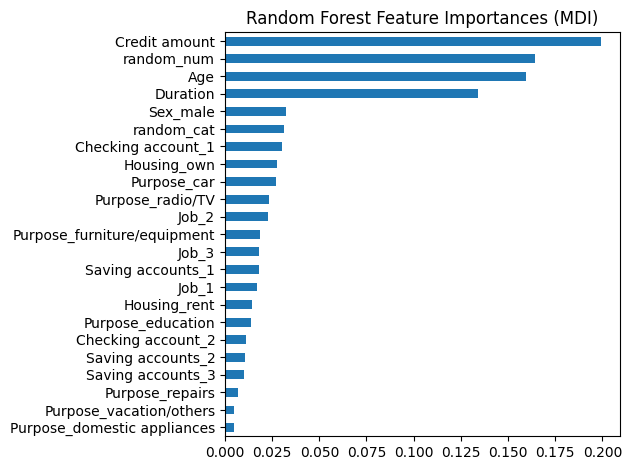

In [108]:
# Obtener los nombres de las características
feature_names = X.columns

# Calcular la importancia de las características
mdi_importances = pd.Series(
    rf_clf.feature_importances_, index=feature_names
).sort_values(ascending=True)

# Visualizar la importancia de las características
ax = mdi_importances.plot.barh()
ax.set_title("Random Forest Feature Importances (MDI)")
ax.figure.tight_layout()

Con el Impurity-based Feature Importance obtenemos mucha importancia (sobre todo de var_num) de variables aleatorias que no tienen nada que aportar al modelo, a parte de por ser un problema específico de este método se debe al overfitting.

### Permutation Feature Importance 

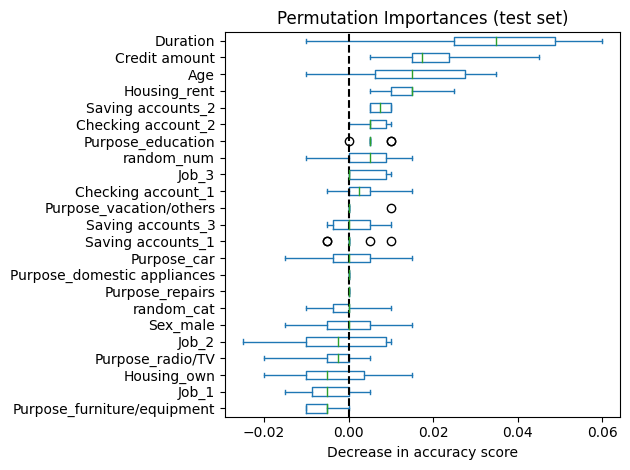

In [109]:
from sklearn.inspection import permutation_importance

# Calcular la importancia de las características por permutación en el conjunto de prueba
result = permutation_importance(
    rf_clf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1
)

# Obtener los nombres de las características
feature_names = X.columns

# Ordenar los índices de importancia
sorted_importances_idx = result.importances_mean.argsort()

# Crear un DataFrame para visualizar las importancias de las características
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=feature_names[sorted_importances_idx]
)

# Visualizar las importancias de las características mediante una caja de bigotes
ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (test set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()


### EXTRA: Prueba overfitting

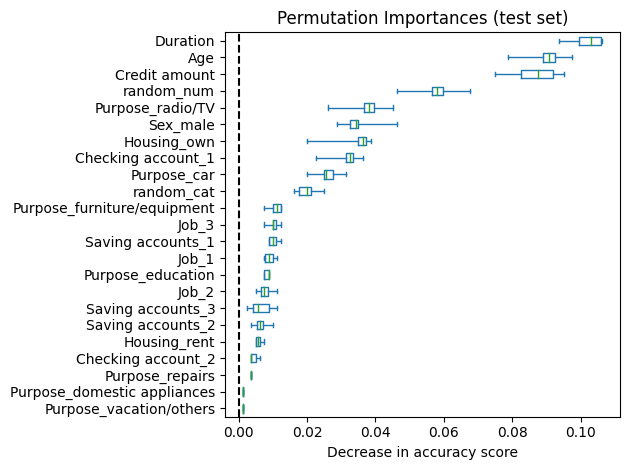

In [89]:
from sklearn.inspection import permutation_importance

# Calcular la importancia de las características por permutación en el conjunto de prueba
result = permutation_importance(
    rf_clf, X_train, y_train, n_repeats=10, random_state=42, n_jobs=-1
)

# Obtener los nombres de las características
feature_names = X.columns

# Ordenar los índices de importancia
sorted_importances_idx = result.importances_mean.argsort()

# Crear un DataFrame para visualizar las importancias de las características
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=feature_names[sorted_importances_idx]
)

# Visualizar las importancias de las características mediante una caja de bigotes
ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (test set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()


# 2. Overfitting y sin variables extra

In [90]:
# Imports necesarios
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Fijamos semilla
import random
random.seed(0)
# Generador aleatorio
rng = np.random.RandomState(seed=0)

nombre_archivo = "data/german_credit_data_prepared.csv"
datos_leidos = pd.read_csv(nombre_archivo)

# Dividir los datos en características (X) y etiquetas (y)
X = datos_leidos.drop('Risk_True', axis=1)  # Características
y = datos_leidos['Risk_True']  # Etiquetas
# Dividir los datos en conjunto de entrenamiento y conjunto de prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_clf = RandomForestClassifier()
rf_clf.fit(X_train, y_train)

print(f"RF train accuracy: {rf_clf.score(X_train, y_train):.3f}")
print(f"RF test accuracy: {rf_clf.score(X_test, y_test):.3f}")

RF train accuracy: 1.000
RF test accuracy: 0.700


In [91]:
rf_clf

RandomForestClassifier()

### Impurity-based Feature Importance 

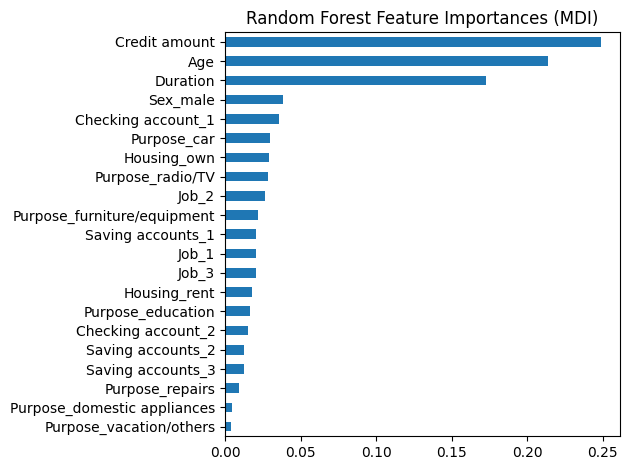

In [92]:
# Obtener los nombres de las características
feature_names = X.columns

# Calcular la importancia de las características
mdi_importances = pd.Series(
    rf_clf.feature_importances_, index=feature_names
).sort_values(ascending=True)

# Visualizar la importancia de las características
ax = mdi_importances.plot.barh()
ax.set_title("Random Forest Feature Importances (MDI)")
ax.figure.tight_layout()

### Permutation Feature Importance 

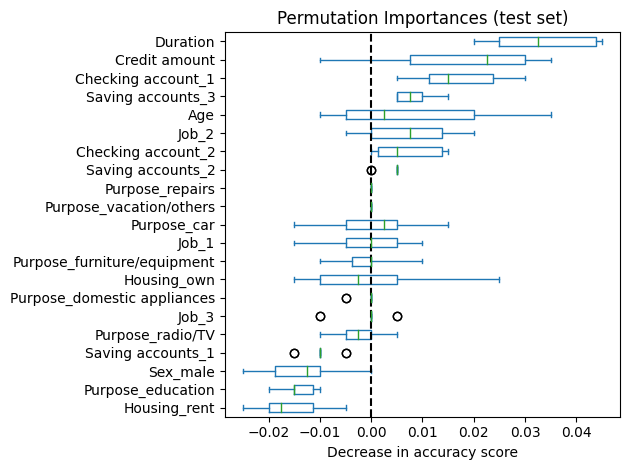

In [93]:
from sklearn.inspection import permutation_importance

# Calcular la importancia de las características por permutación en el conjunto de prueba
result = permutation_importance(
    rf_clf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1
)

# Obtener los nombres de las características
feature_names = X.columns

# Ordenar los índices de importancia
sorted_importances_idx = result.importances_mean.argsort()

# Crear un DataFrame para visualizar las importancias de las características
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=feature_names[sorted_importances_idx]
)

# Visualizar las importancias de las características mediante una caja de bigotes
ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (test set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()


### EXTRA: Prueba overfitting

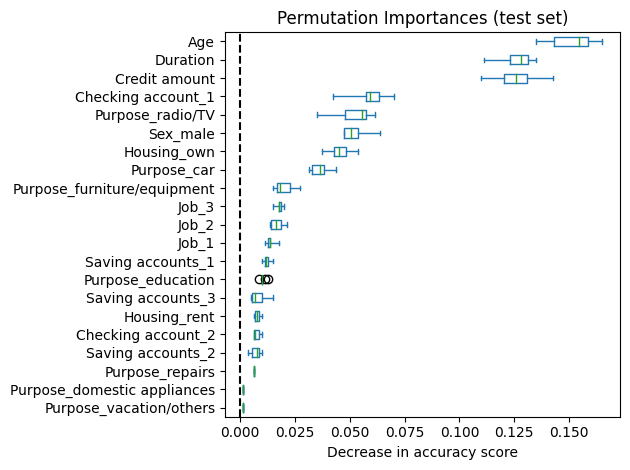

In [94]:
from sklearn.inspection import permutation_importance

# Calcular la importancia de las características por permutación en el conjunto de prueba
result = permutation_importance(
    rf_clf, X_train, y_train, n_repeats=10, random_state=42, n_jobs=-1
)

# Obtener los nombres de las características
feature_names = X.columns

# Ordenar los índices de importancia
sorted_importances_idx = result.importances_mean.argsort()

# Crear un DataFrame para visualizar las importancias de las características
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=feature_names[sorted_importances_idx]
)

# Visualizar las importancias de las características mediante una caja de bigotes
ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (test set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()


# 3. Overfitting y con variables extra

In [95]:
# Imports necesarios
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier


Fijamos semilla.

In [96]:
import random
random.seed(6)

In [97]:
nombre_archivo = "data/german_credit_data_prepared.csv"

datos_leidos = pd.read_csv(nombre_archivo)
# Añadir variables aleatorias
datos_leidos["random_cat"] = rng.randint(2, size=datos_leidos.shape[0])
datos_leidos["random_num"] = rng.randn(datos_leidos.shape[0])

In [98]:
# Dividir los datos en características (X) y etiquetas (y)
X = datos_leidos.drop('Risk_True', axis=1)  # Características
y = datos_leidos['Risk_True']  # Etiquetas

# Dividir los datos en conjunto de entrenamiento y conjunto de prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [99]:
rf_clf = RandomForestClassifier(bootstrap=True,
                                 max_depth=11,
                                 max_features='sqrt',
                                 min_samples_leaf=4,
                                 min_samples_split=10,
                                 n_estimators=100)
rf_clf.fit(X_train, y_train)

print(f"RF train accuracy: {rf_clf.score(X_train, y_train):.3f}")
print(f"RF test accuracy: {rf_clf.score(X_test, y_test):.3f}")

RF train accuracy: 0.799
RF test accuracy: 0.700


Realmente obtengo más precisión con el umbral optimizado.

### Optimizar Umbrales

Lo he hecho directamente sobre todos los datos.

In [100]:
import sys
sys.path.append('../')
import Umbrales  

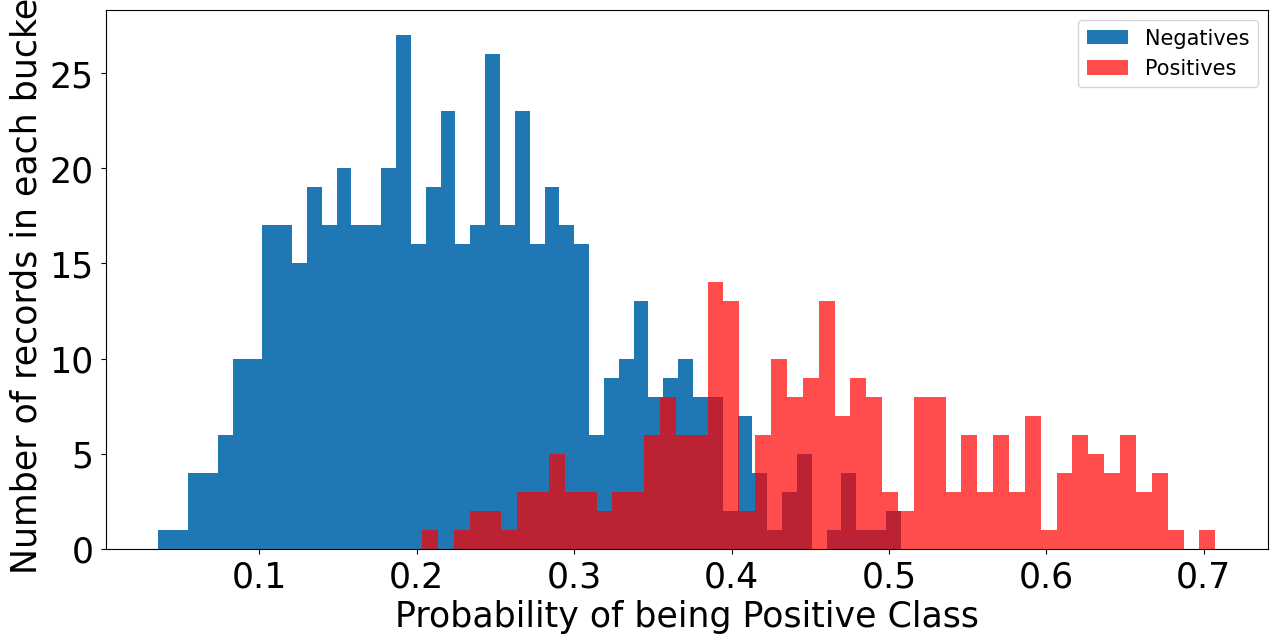

In [101]:
Umbrales.plot_prob(rf_clf, X_train, y_train)


Precisión con umbral nuevo: 0.832
Informe de clasificación con umbral nuevo:
              precision    recall  f1-score   support

           0       0.84      0.94      0.89       700
           1       0.81      0.58      0.67       300

    accuracy                           0.83      1000
   macro avg       0.82      0.76      0.78      1000
weighted avg       0.83      0.83      0.82      1000



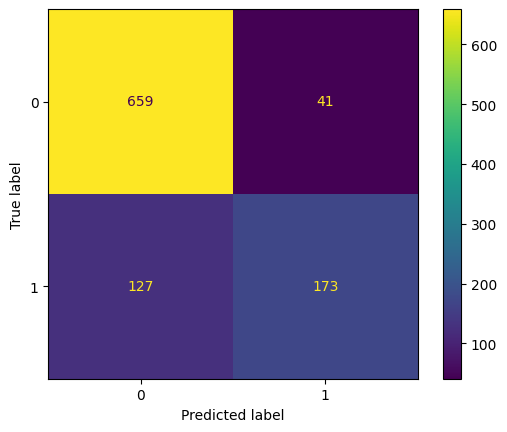

In [102]:
Umbrales.report_umbral(0.41, rf_clf, X, y)

### Impurity-based Feature Importance 

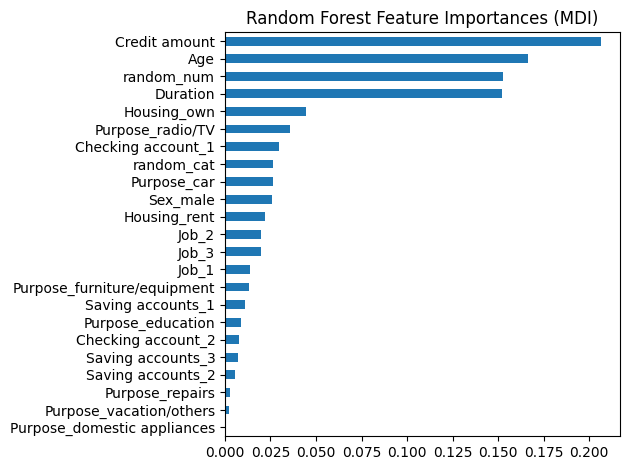

In [103]:
# Obtener los nombres de las características
feature_names = X.columns

# Calcular la importancia de las características
mdi_importances = pd.Series(
    rf_clf.feature_importances_, index=feature_names
).sort_values(ascending=True)

# Visualizar la importancia de las características
ax = mdi_importances.plot.barh()
ax.set_title("Random Forest Feature Importances (MDI)")
ax.figure.tight_layout()

### Permutation Feature Importance 

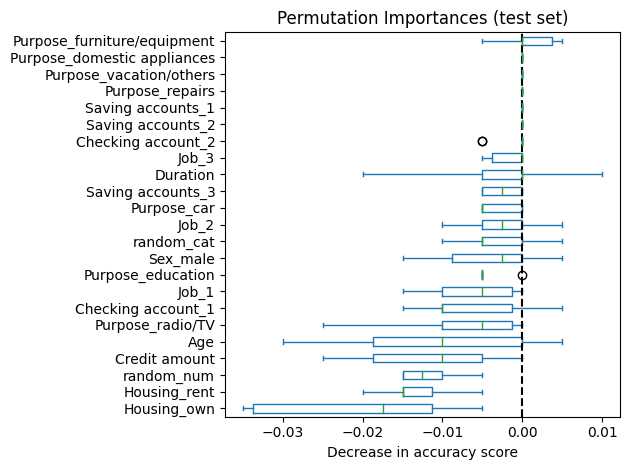

In [104]:
from sklearn.inspection import permutation_importance

# Calcular la importancia de las características por permutación en el conjunto de prueba
result = permutation_importance(
    rf_clf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1
)

# Obtener los nombres de las características
feature_names = X.columns

# Ordenar los índices de importancia
sorted_importances_idx = result.importances_mean.argsort()

# Crear un DataFrame para visualizar las importancias de las características
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=feature_names[sorted_importances_idx]
)

# Visualizar las importancias de las características mediante una caja de bigotes
ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (test set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()


### EXTRA: Prueba overfitting

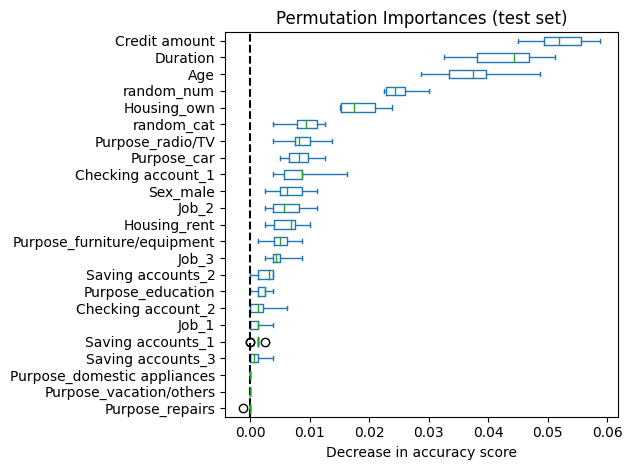

In [105]:
from sklearn.inspection import permutation_importance

# Calcular la importancia de las características por permutación en el conjunto de prueba
result = permutation_importance(
    rf_clf, X_train, y_train, n_repeats=10, random_state=42, n_jobs=-1
)

# Obtener los nombres de las características
feature_names = X.columns

# Ordenar los índices de importancia
sorted_importances_idx = result.importances_mean.argsort()

# Crear un DataFrame para visualizar las importancias de las características
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=feature_names[sorted_importances_idx]
)

# Visualizar las importancias de las características mediante una caja de bigotes
ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (test set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()


# 4. Overfitting y sin variables extra

In [53]:
# Imports necesarios
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier


Fijamos semilla.

In [54]:
import random
random.seed(6)

In [55]:
nombre_archivo = "data/german_credit_data_prepared.csv"

datos_leidos = pd.read_csv(nombre_archivo)

In [56]:
# Dividir los datos en características (X) y etiquetas (y)
X = datos_leidos.drop('Risk_True', axis=1)  # Características
y = datos_leidos['Risk_True']  # Etiquetas

# Dividir los datos en conjunto de entrenamiento y conjunto de prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [57]:
rf_clf = RandomForestClassifier(bootstrap=True,
                                 max_depth=11,
                                 max_features='sqrt',
                                 min_samples_leaf=4,
                                 min_samples_split=10,
                                 n_estimators=100)
rf_clf.fit(X_train, y_train)

print(f"RF train accuracy: {rf_clf.score(X_train, y_train):.3f}")
print(f"RF test accuracy: {rf_clf.score(X_test, y_test):.3f}")

RF train accuracy: 0.799
RF test accuracy: 0.715


Realmente obtengo más precisión con el umbral optimizado.

### Optimizar Umbrales

Lo he hecho directamente sobre todos los datos.

In [60]:
import sys
sys.path.append('../')
import Umbrales  

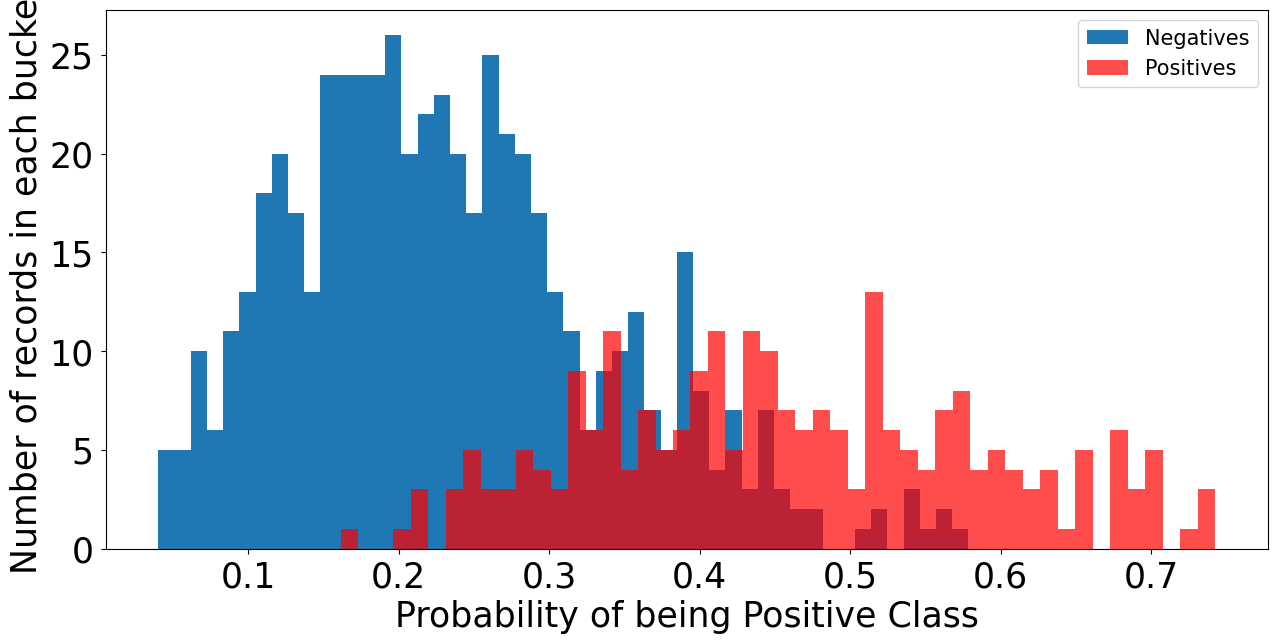

In [61]:
Umbrales.plot_prob(rf_clf, X_train, y_train)


Precisión con umbral nuevo: 0.81
Informe de clasificación con umbral nuevo:
              precision    recall  f1-score   support

           0       0.83      0.92      0.87       700
           1       0.75      0.56      0.64       300

    accuracy                           0.81      1000
   macro avg       0.79      0.74      0.75      1000
weighted avg       0.80      0.81      0.80      1000



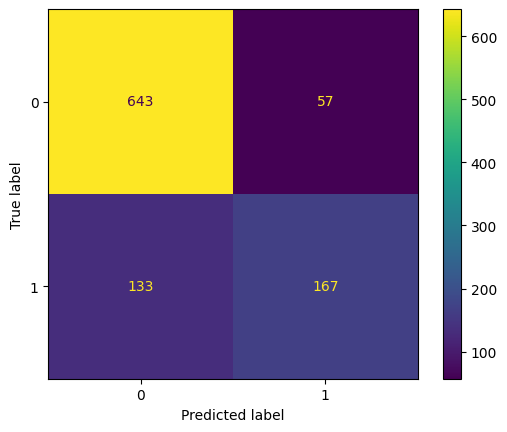

In [62]:
Umbrales.report_umbral(0.41, rf_clf, X, y)

### Impurity-based Feature Importance 

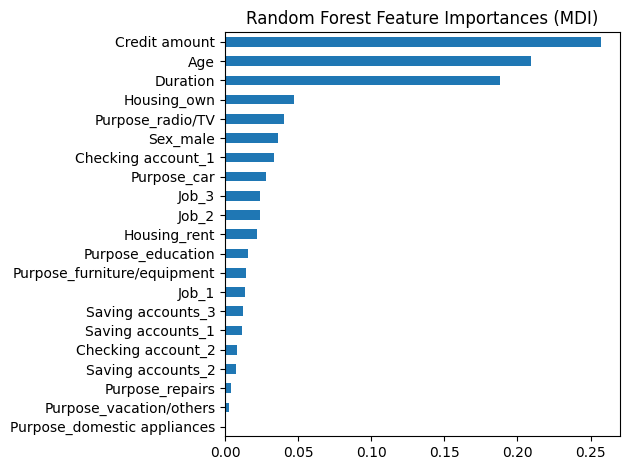

In [ ]:
# Obtener los nombres de las características
feature_names = X.columns

# Calcular la importancia de las características
mdi_importances = pd.Series(
    rf_clf.feature_importances_, index=feature_names
).sort_values(ascending=True)

# Visualizar la importancia de las características
ax = mdi_importances.plot.barh()
ax.set_title("Random Forest Feature Importances (MDI)")
ax.figure.tight_layout()

### Permutation Feature Importance 

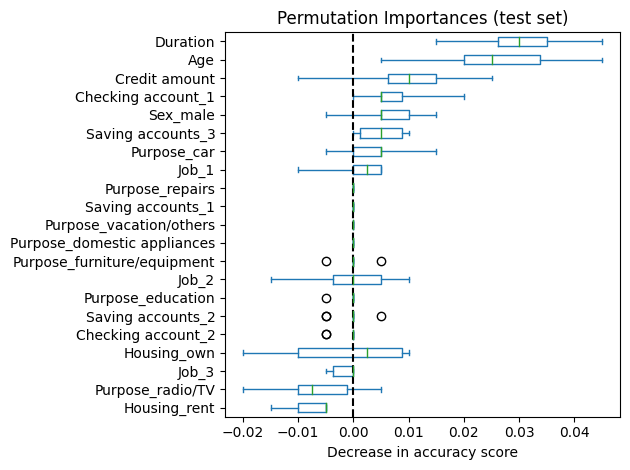

In [ ]:
from sklearn.inspection import permutation_importance

# Calcular la importancia de las características por permutación en el conjunto de prueba
result = permutation_importance(
    rf_clf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1
)

# Obtener los nombres de las características
feature_names = X.columns

# Ordenar los índices de importancia
sorted_importances_idx = result.importances_mean.argsort()

# Crear un DataFrame para visualizar las importancias de las características
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=feature_names[sorted_importances_idx]
)

# Visualizar las importancias de las características mediante una caja de bigotes
ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (test set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()


# ANEXOS

## ANEXO A: Interpretación Naive pre modelización

La interpretación general que doy es la siguiente:
 - Dado que la base de datos ya estaba bastante preparada, todas las variables aportan a la predicción, siendo claramente las más importantes la cantidad del préstamo y la duracción.
 - La cantidad del préstamo y la duracción afectan negativamente a la predicción, es decir los préstamos más grandes y más largos tienen mayor riesgo. Estas dos variables están correlacionadas lo cual es lógico. Habría que tener en cuenta como comentamos que hay que relativizar los impagos de larga duración pues no es lo mismo un impago de 30 años que un impago de 6 meses. Pero en general estas dos variables son las que más afectan a la predicción.
 - Las variables como ahorros, dinero en la cuenta, si tienen casa o viven de alquiler, el tipo de trabajo resultan totalmente intuitivos, cuanto mejor la situación (más ahorros, más dinero en la cuenta, tener casa en vez de vivir de alquiler...) menos riego de impago.
 - La edad disminuye el riesgo de impago, tiene sentido si pensamos que la gente mayor es más sensata, arriesga menos que los jóvenes y suelen tener mayor estabilidad financiera.
 - Es curioso el caso de que ser hombre disminuye el riesgo de impago, debe haber muchos factores involucrados pero me sorprende porque creo que en general los hombres suelen ser más agresivos en las finanzas.
 - Finalmente el motivo también afecta al riesgo, esta es la variable más difícil de intuir. En mi opinión, parece que tiene sentido que gastos menores o más necesarios tengan menos riesgo como puede ser la necesidad de un coche para trabajar o un gasto menor como puede ser una radio (relación con cantidad de préstamo como  hemos comentado), y tiene sentido que propósitos como vacaciones que son secundarios (y que no deberías pedir un préstamo para ellos, parece que es querer vivir por encima de su nivel financiero) aumenten la probabilidad de impago. Aún así no me encaja el propósito de educación, creo que puede ser que esté afectado por el abandono de los estudios.